# Análisis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [ ]:
# lo primero es llamar  a las variables de respuesta y a covariables

Respuesta = pd.read_csv("Votos_por_Municipio.csv",encoding = "utf8")
Covariables = pd.read_csv("Base_censo.csv", encoding = "utf8")

print(f"Total de filas de la base Respuesta {Respuesta.shape[0]}")
print(f"Total de filas de la base Covariables {Covariables.shape[0]}")

Total de filas de la base Respuesta 2463
Total de filas de la base Covariables 2469


El total de filas no coincide, vamos a trabajar solo con el total de las filas de la variable de respuesta. 

In [96]:
Base = pd.merge(Respuesta, Covariables , on ="C_Municipio")

print(f"El total de las filas de Base es {Base.shape[0]}")

El total de las filas de Base es 2463


In [97]:
# hay que verificar que se hizo un buen Merge
print(Base.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 36 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   C_Municipio  2463 non-null   object 
 1   AMLO         2463 non-null   float64
 2   Anaya        2463 non-null   float64
 3   Total_Votos  2463 non-null   int64  
 4   ENTIDAD_x    2463 non-null   int64  
 5   MUN_x        2463 non-null   int64  
 6   NOM_ENT      2463 non-null   object 
 7   ENTIDAD_y    2463 non-null   int64  
 8   NOM_MUN      2463 non-null   object 
 9   MUN_y        2463 non-null   int64  
 10  POBMAS       2463 non-null   float64
 11  POBFEM       2463 non-null   float64
 12  P_18A29      2463 non-null   float64
 13  P_18A29_F    2463 non-null   float64
 14  P_18A29_M    2463 non-null   float64
 15  P_30A44      2463 non-null   float64
 16  P_30A44_M    2463 non-null   float64
 17  P_30A44_F    2463 non-null   float64
 18  P_45A59      2463 non-null   float64
 19  P_45A5

El merge se realizo bien.

## Analisis exploratorio

Relacion de las ambas variables de respuesta

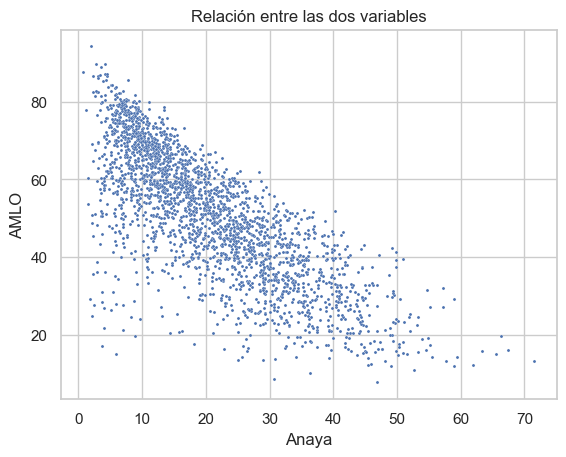

In [98]:
sns.scatterplot(Base, x="Anaya", y="AMLO",s=5)

plt.title("Relación entre las dos variables")
plt.xlabel("Anaya")
plt.ylabel("AMLO")
plt.show()

In [99]:
# Se observa que ambas variables estan relacionadas
cor =  Base["Anaya"].corr(Base["AMLO"])
print(f"La correlación esta dada por {cor}")

La correlación esta dada por -0.766786108053389


La correlación negativa entre las variables sugieren la presencia de factores no observados que favorecen sistemáticamente a un candidato mientras perjudican al otro, lo que indica una dinámica competitiva en la asignación del voto.

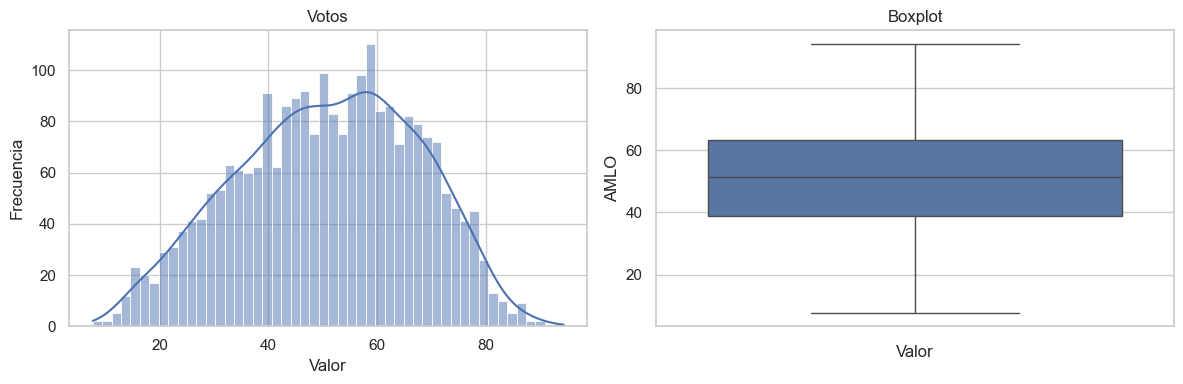

In [100]:
# Base de Trabajo para AMLO 
BaseA = Base.iloc[:, [1] + list(range(12,36))]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Histograma
sns.histplot(BaseA["AMLO"], kde=True, ax=axes[0], bins = 50)
axes[0].set_title("Votos")
axes[0].set_xlabel("Valor")
axes[0].set_ylabel("Frecuencia")

sns.boxplot(BaseA["AMLO"], ax=axes[1])
axes[1].set_title("Boxplot")
axes[1].set_xlabel("Valor")

plt.tight_layout()
plt.show()

No hay valores atipicos o extremos, la distribucion tiene ligero sesgo. Esto es un buen indicio que sugiere que se puede realizar un analisis paramétrico. 

Respecto a las covariables se tienen variables numericas, no categoricas. Realizaremos las siguientes transformaciones.

In [109]:
my_corr = BaseA.corr()

Las correlaciones son muy pequeñas, vamos a probar con interacciones entre covariables

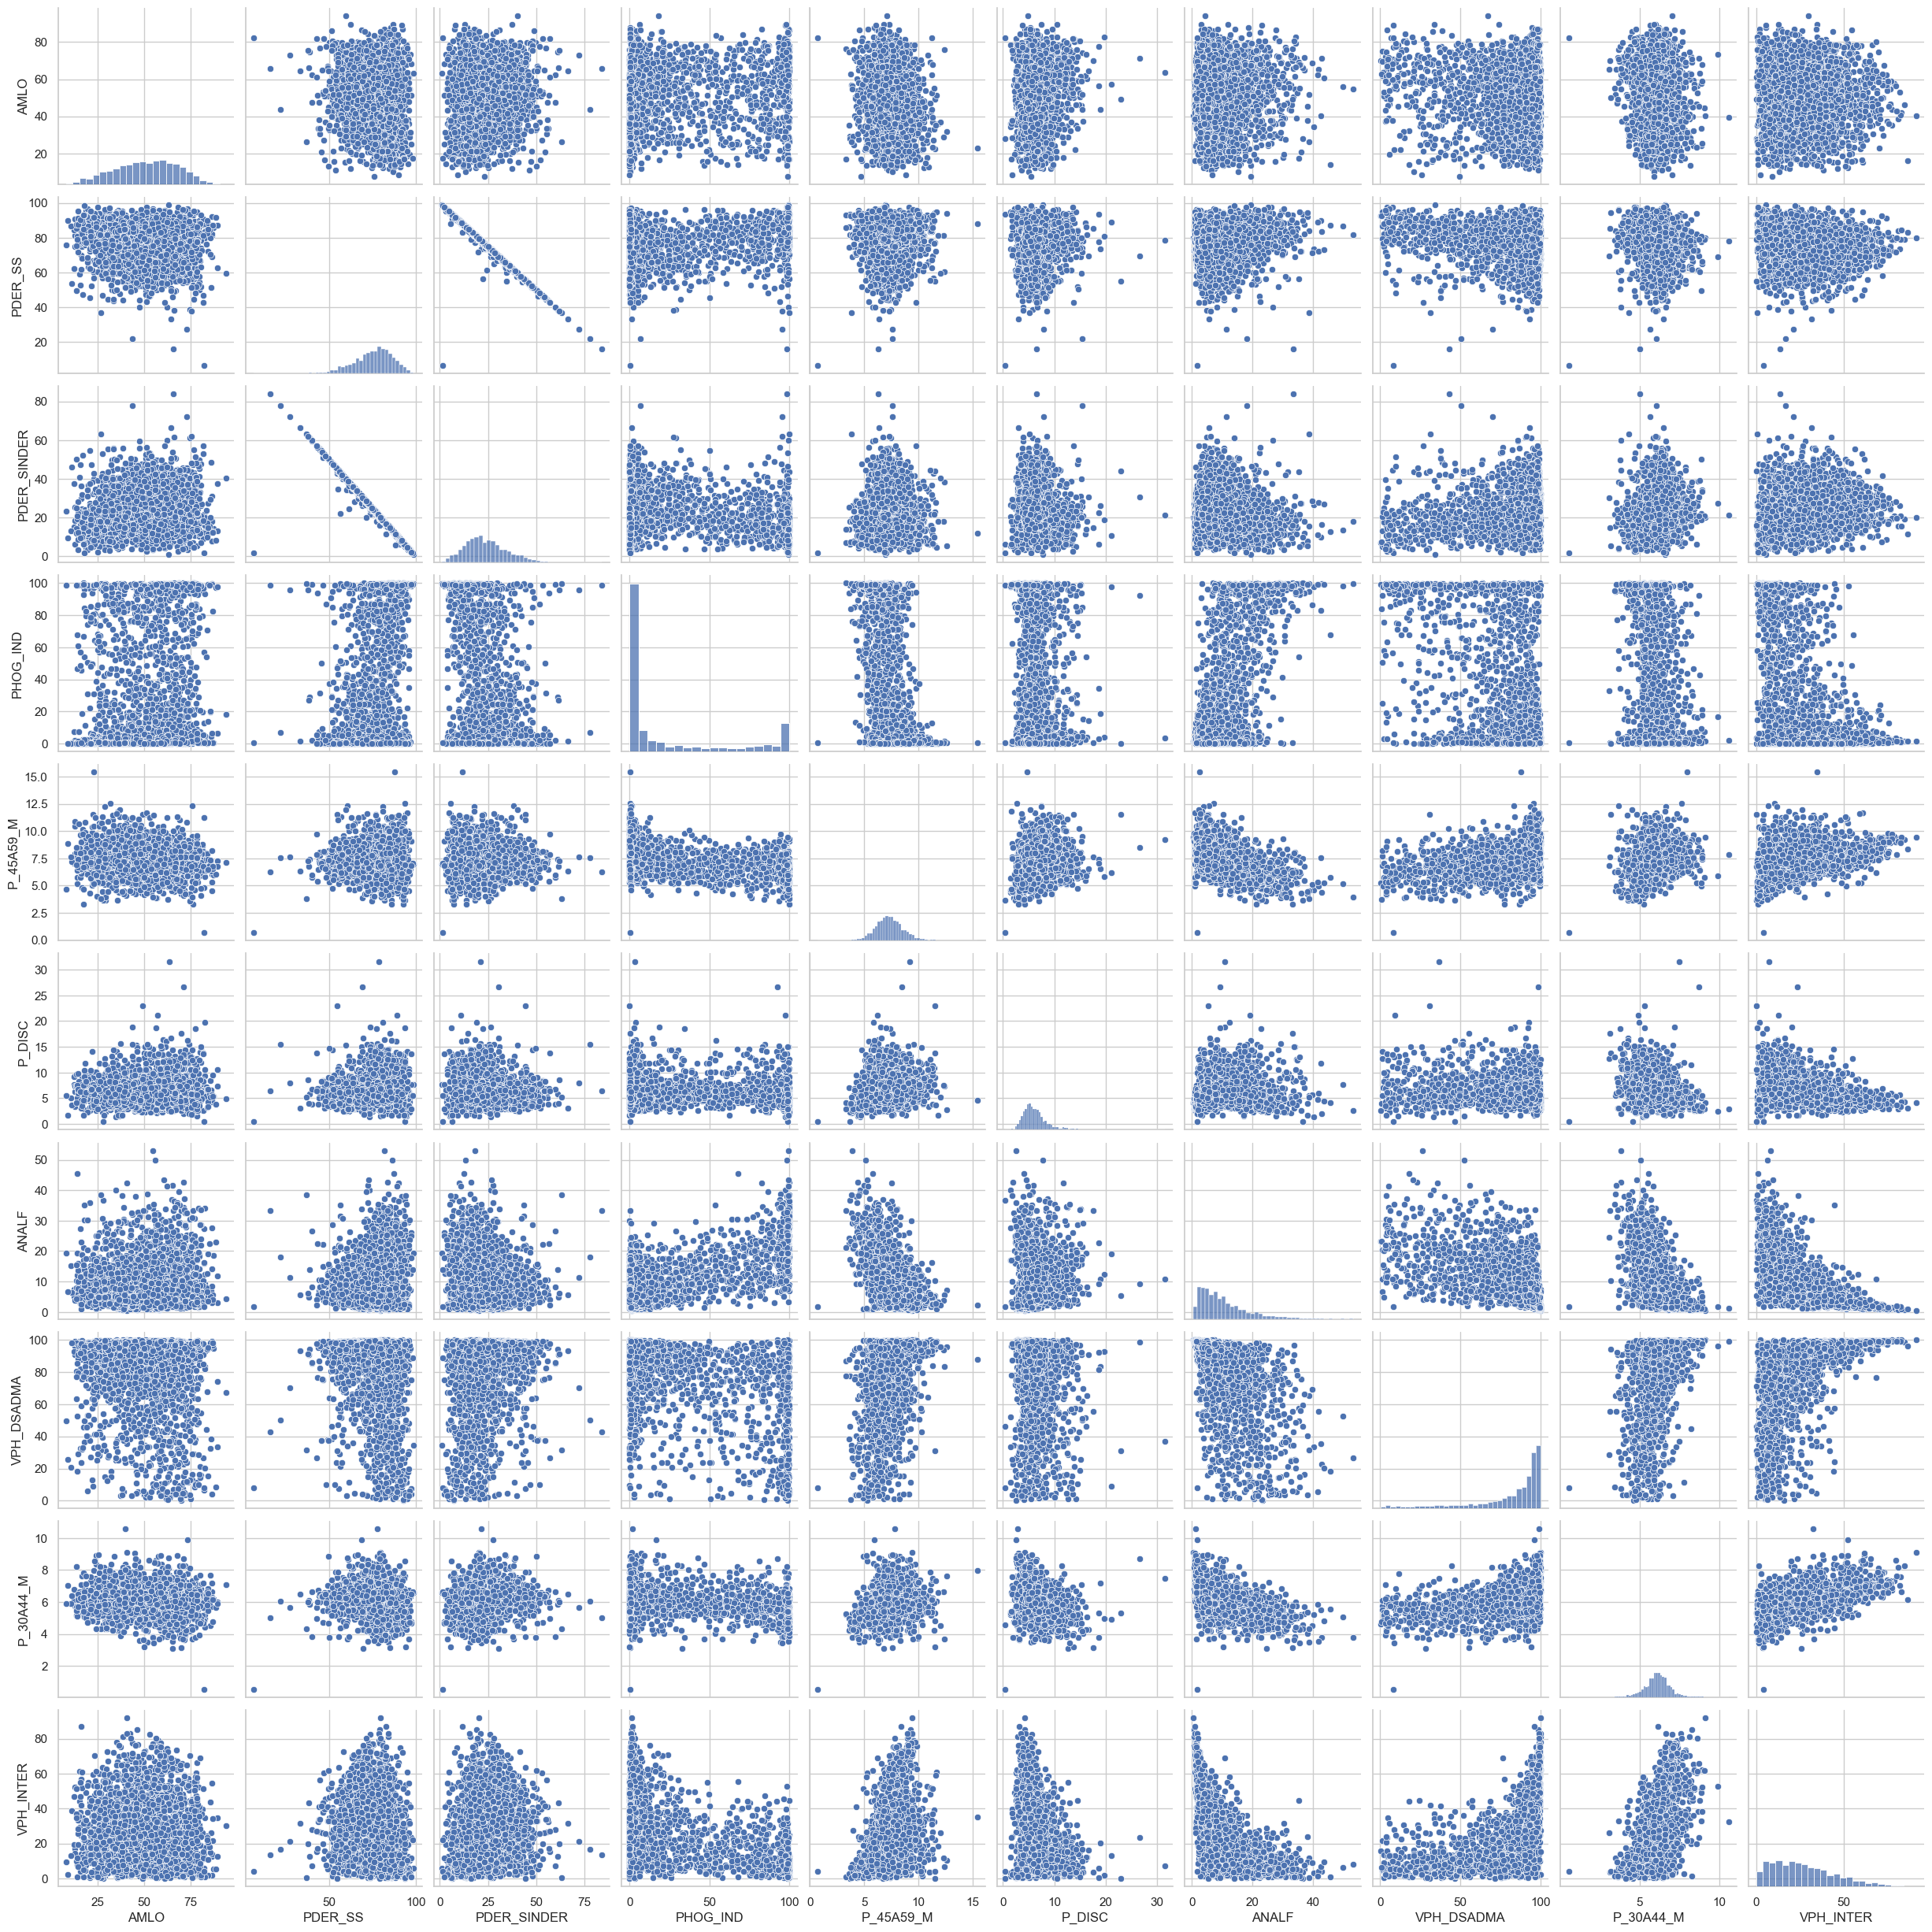

In [113]:

# Ordenar por correlacion absoluta con AMLO, me quedo con las 10 variables que tenen mas poder explicativo 
my_cororder = my_corr["AMLO"].abs().sort_values(ascending=False)
top_vars = my_cororder.index[:10]
sns.pairplot(BaseA[top_vars])
plt.show()

In [110]:
top_vars

Index(['AMLO', 'PDER_SS', 'PDER_SINDER', 'PHOG_IND', 'P_45A59_M', 'P_DISC',
       'ANALF', 'VPH_DSADMA', 'P_30A44_M', 'VPH_INTER'],
      dtype='object')

In [108]:
y = BaseA["AMLO"]
X = BaseA.drop(columns="AMLO")
X_const = sm.add_constant(X)

In [ ]:
# --------------------------------------------
# BOOTSTRAP DE COEFICIENTES
# --------------------------------------------

B = 10000
n = Base.shape[0]

# Variable dependiente e independientes
y = Base["AMLO"]
X = Base.drop(columns="AMLO")
X_const = sm.add_constant(X)

p = X.shape[1]
betas = np.zeros((p + 1, B))

# Bootstrap
for tt in range(B):
    idx = np.random.choice(n, n, replace=True)
    X_star = X_const.iloc[idx]
    y_star = y.iloc[idx]

    model = sm.OLS(y_star, X_star).fit()
    betas[:, tt] = model.params.values

# --------------------------------------------
# INFERENCIA BOOTSTRAP (IC 95%)
# --------------------------------------------

alpha = 0.05

res_beta = pd.DataFrame(
    index=["Inter"] + list(X.columns),
    columns=["Estim", "L", "U"],
    dtype=float
)

# Estimaciones puntuales
model_full = sm.OLS(y, X_const).fit()
res_beta["Estim"] = model_full.params.values

# Intervalos de confianza bootstrap
for j in range(p + 1):
    res_beta.iloc[j, 1:] = np.quantile(
        betas[j, :],
        [alpha / 2, 1 - alpha / 2]
    )

print(res_beta)

# --------------------------------------------
# MODELO LINEAL COMPLETO
# --------------------------------------------

print(model_full.summary())

# --------------------------------------------
# SELECCION DE VARIABLES STEPWISE (AIC)
# --------------------------------------------

def stepwise_selection(X, y, initial_list=None,
                       threshold_in=0.01,
                       threshold_out=0.05,
                       verbose=True):
    if initial_list is None:
        initial_list = []

    included = list(initial_list)

    while True:
        changed = False

        # Paso hacia adelante
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)

        for col in excluded:
            model = sm.OLS(y, sm.add_constant(X[included + [col]])).fit()
            new_pval[col] = model.pvalues[col]

        if not new_pval.empty:
            best_pval = new_pval.min()
            if best_pval < threshold_in:
                best_feature = new_pval.idxmin()
                included.append(best_feature)
                changed = True
                if verbose:
                    print(f"Add {best_feature} p={best_pval:.4f}")

        # Paso hacia atras
        if included:
            model = sm.OLS(y, sm.add_constant(X[included])).fit()
            pvalues = model.pvalues.iloc[1:]
            worst_pval = pvalues.max()

            if worst_pval > threshold_out:
                worst_feature = pvalues.idxmax()
                included.remove(worst_feature)
                changed = True
                if verbose:
                    print(f"Drop {worst_feature} p={worst_pval:.4f}")

        if not changed:
            break

    return included

# Aplicacion del stepwise (modelo base GRAPROES)
selected_vars = stepwise_selection(
    X,
    y,
    initial_list=["GRAPROES"],
    verbose=True
)

print("Variables seleccionadas:", selected_vars)

# --------------------------------------------
# MODELO FINAL
# --------------------------------------------

X_sel = sm.add_constant(X[selected_vars])
final_model = sm.OLS(y, X_sel).fit()

print(final_model.summary())

# Coeficientes
print(final_model.params)

# R2 y R2 ajustado
print("R2:", final_model.rsquared)
print("R2 ajustado:", final_model.rsquared_adj)